## 科学论文数据提取流程 (使用 OpenRouter + DeepSeek-v3)

演示如何使用大语言模型构建一个自动化系统，从关于阴离子交换膜（AEMs）的科学论文中提取结构化数据。

**本版本使用 OpenRouter 的 DeepSeek-v3 模型：**
- 🚀 **高性能**: 671B参数的先进模型
- 💰 **免费使用**: OpenRouter免费额度
- 🧠 **科学文本专长**: 优秀的技术文档理解能力

如果条件允许，可以用本地模型或阿里云百炼大模型API

## 步骤1：设置OpenRouter API KEY、DeepSeek-v3模型配置等。
🔑 OpenRouter API 密钥设置

**在运行此笔记本之前，您需要设置您的 OpenRouter API 密钥：**

1. **获取免费的 OpenRouter API 密钥：**
   - 访问 [OpenRouter.ai](https://openrouter.ai/)
   - 注册一个免费账户
   - 前往 API 密钥部分并创建一个新密钥

2. **设置环境变量：**
   ```bash
   # 选项 1：在您的终端/命令提示符中设置
   export OPENROUTER_API_KEY="your_api_key_here"
   
   # 选项 2：在 Python 中设置（安全性较低）
   import os
   os.environ["OPENROUTER_API_KEY"] = "your_api_key_here"
   ```


In [ ]:
# Step 1: Import Required Libraries
import sys
import os
import sqlite3
import time
import json
import re
import math
import random
from datetime import datetime
from pathlib import Path
from typing import List, Optional, Union

# Core ML and API libraries
from pydantic import BaseModel, ConfigDict
from openai import OpenAI
import tiktoken

# Data processing
import pandas as pd
import jsonlines
import json_repair

print("✅ All libraries imported successfully!")
print(f"📍 Current working directory: {Path.cwd()}")

# OpenRouter Configuration for DeepSeek-v3
API_KEY = "<your_api_key>"
MODEL_NAME = "deepseek/deepseek-chat-v3-0324:free"  # DeepSeek-v3 free model
TEMPERATURE = 0
BASE_URL = "https://openrouter.ai/api/v1"

print(f"🤖 Model: {MODEL_NAME}")
print(f"🔑 OpenRouter API Key configured: {'Yes' if API_KEY else 'No'}")
print(f"🌐 Base URL: {BASE_URL}")

# Set random seed for reproducibility
random.seed(1234)

✅ All libraries imported successfully!
📍 Current working directory: c:\Users\HYPER\VScode\Agent-demo
🤖 Model: deepseek/deepseek-chat-v3-0324:free
🔑 OpenRouter API Key configured: Yes
🌐 Base URL: https://openrouter.ai/api/v1


# 步骤2：数据结构设计与Prompt工程和Prompt设计

我们使用**Pydantic**来定义结构化数据模型，确保类型安全和验证。这种方法帮助AI理解我们期望的确切数据格式。

## 为什么选择Pydantic？
- ✅ **类型验证** - 确保数据完整性
- ✅ **JSON模式生成** - 帮助AI理解结构
- ✅ **清晰的文档** - 自文档化模型
- ✅ **错误处理** - 早期捕获格式错误的数据

## 我们的数据层次结构

```
DataList (根)
├── data_entries: List[DataEntry]
└── thought_process: str

DataEntry (每个AEM)
├── aem_name: str
├── oh_conductivity: OhConductivityProperty
├── swelling_ratio: SwellingRatioProperty
├── tensile_strength: TensileStrengthProperty
├── water_uptake: WaterUptakeProperty
```

## 📝 Prompt设计原则

在科学数据提取任务中，**有效的prompt设计**与**结构化数据模型**同样重要。我们的prompt设计遵循以下核心原则：

### 🎯 核心设计原则

#### 1. **分层指令结构**
```
角色定义 → 任务描述 → 具体步骤 → 输出格式 → 示例
```

#### 2. **精确的领域术语**
- 使用科学文献中的标准术语
- 提供关键词和同义词列表
- 明确单位和测量条件

#### 3. **结构化输出约束**
- 与Pydantic模型严格对应
- 明确字段类型和可选性
- 提供JSON格式示例

#### 4. **上下文感知指引**
- 区分"本研究"与"引用文献"的数据
- 处理多条件测量的复杂情况
- 明确缺失数据的处理方式

In [2]:
# Step 2A: Helper Models for Value-Unit Pairs

class ValueUnit(BaseModel):
    """Represents a scientific measurement with value and unit."""
    value: Union[str, float, int, None]
    unit: Optional[str]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

class ValueOnly(BaseModel):
    """Represents a value without unit (e.g., testing solution name)."""
    value: Optional[str]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

# Test our basic models
test_conductivity = ValueUnit(value=78.4, unit="mS cm-1")
test_solution = ValueOnly(value="1 M KOH")

print("🧪 Testing basic models:")
print(f"Conductivity: {test_conductivity}")
print(f"Solution: {test_solution}")
print("✅ Basic models work correctly!")


🧪 Testing basic models:
Conductivity: value=78.4 unit='mS cm-1'
Solution: value='1 M KOH'
✅ Basic models work correctly!


In [3]:
# Step 2B: Property-Specific Models
class OhConductivityProperty(BaseModel):
    """Represents inherent OH⁻ conductivity."""
    oh_conductivity: Optional[ValueUnit]
    testing_temperature: Optional[ValueUnit]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

class SwellingRatioProperty(BaseModel):
    """Represents dimensional changes in liquid."""
    swelling_ratio: Optional[ValueUnit]
    testing_temperature: Optional[ValueUnit]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

class TensileStrengthProperty(BaseModel):
    """Represents mechanical strength properties."""
    tensile_strength: Optional[ValueUnit]
    testing_temperature: Optional[ValueUnit]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

class WaterUptakeProperty(BaseModel):
    """Represents water absorption capacity."""
    water_uptake: Optional[ValueUnit]
    testing_temperature: Optional[ValueUnit]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

print("🏗️ Property-specific models defined!")
print(f"📊 Total property types: 6")

🏗️ Property-specific models defined!
📊 Total property types: 6


In [4]:
# Step 2C: Main Data Structure Models

class DataEntry(BaseModel):
    """Represents complete data for one AEM membrane."""
    aem_name: str
    oh_conductivity: Optional[Union[OhConductivityProperty, List[OhConductivityProperty]]]
    swelling_ratio: Optional[Union[SwellingRatioProperty, List[SwellingRatioProperty]]]
    tensile_strength: Optional[Union[TensileStrengthProperty, List[TensileStrengthProperty]]]
    water_uptake: Optional[Union[WaterUptakeProperty, List[WaterUptakeProperty]]]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

class DataList(BaseModel):
    """Top-level container for all extracted data."""
    data_entries: List[DataEntry]
    model_config = ConfigDict(extra="allow", json_schema_extra={"additionalProperties": False})

# Generate JSON schema for structured output (compatible with OpenRouter/DeepSeek-v3)
# Note: DeepSeek-v3 may not support OpenAI's strict JSON schema format
# We'll use the schema as reference but not enforce strict mode
response_format = {
    "type": "json_object"
}

# Keep the schema for reference in prompts
data_schema = DataList.model_json_schema()

print("📋 Main data structures defined!")
print("✅ JSON schema ready for OpenRouter API (DeepSeek-v3)")

# Let's examine our schema structure
schema = DataList.model_json_schema()
print(f"\n🔍 Schema has {len(schema['properties'])} top-level properties:")
for prop in schema['properties']:
    print(f"   • {prop}")
    
print(f"\n📝 DataEntry has {len(schema['$defs']['DataEntry']['properties'])} properties:")


📋 Main data structures defined!
✅ JSON schema ready for OpenRouter API (DeepSeek-v3)

🔍 Schema has 1 top-level properties:
   • data_entries

📝 DataEntry has 5 properties:


In [5]:
instructions = """
You are an AI assistant specialized in extracting structured data about Anionic Exchange Membranes (AEMs) from research papers.
Your objective is to parse the provided CONTEXT, identify all unique AEMs, and extract specific properties for each AEM. You must adhere strictly to the specified instructions, reasoning steps, and output format. The final output must be a single JSON object containing the extracted data entries.
You will be provided with text (CONTEXT) from a research paper. Your task is to extract information according to the schema and guidelines below.
"""

aem_identification = """
## 1. AEM Identification
   - **Action**: Read the entire CONTEXT to identify all unique Anionic Exchange Membrane (AEM) names mentioned.
   - **Restriction**: Only consider AEMs for which data is reported as part of this study. Ignore AEMs that are only referenced or cited from other research papers.
   - **Output**: Each unique AEM name (from this study) must result in a distinct `DataEntry` object. Ensure all such AEMs are included in the final `data_entries` list.
   - **Note**: Prioritize extracting data for AEM membranes that are reported and studied in this paper (i.e., "This study"). Ignore or skip AEM membranes and data that are only referenced or cited from other research papers. Do not include DataEntry objects for referenced AEMs from other works; only include those for AEMs with data originating from the current CONTEXT.
"""

# Part 4: Targeted Property Extraction
targeted_property_extraction = """
## 2. Targeted Property Extraction
   - **Action**: For each identified AEM, you MUST attempt to extract data ONLY for the following **four target properties**.
   - If a target property for an AEM is not mentioned in the CONTEXT, that property's field MUST be `null`. Do NOT invent data or assume default values.
   - If a single target property for a specific AEM has multiple reported values or distinct tests (e.g., measured under different conditions, temperatures, or times), you MUST represent that property field as a list of its corresponding complex structure objects (as defined for each property below). Each object in the list will contain the primary metric(s) and their associated condition(s).
   - **Exception**: For `oh_conductivity`, if multiple values at different temperatures are reported for a single membrane, extract the highest value and its corresponding temperature; this property should therefore be a single complex object or `null`, not a list.
   - **Properties & Identification Guidelines**: Use the descriptions, keywords, examples, and specific requirements below to help identify each property and its associated data. Each sub-field representing a measured quantity or its condition typically follows a `{"value": ..., "unit": ...}` structure, or `{"value": ...}` for conditions like `testing_solution`.
"""

# Part 5: Property Descriptions
property_descriptions = """
### Property Descriptions

- **`oh_conductivity`**:
  - **Description**: The inherent hydroxide (OH-) or ionic conductivity of the membrane material itself, typically measured at one or more specified temperatures. Symbol is σ. If multiple conductivity values are reported for a single membrane at different temperatures, extract the **highest value** and its corresponding temperature. This property field will be a single object or `null`.
  - **Keywords**: OH- conductivity, ionic conductivity, σ, mS cm-1, mS/cm, hydroxide transport, conductivity in water, conductivity in KOH/NaOH, alkaline conductivity.
  - **Structure**: A single object (or `null`) with the following top-level sub-fields:
    - `oh_conductivity`: (object) `{"value": (numeric), "unit": (string)}` (OH- conductivity value)
    - `testing_temperature`: (object) `{"value": (numeric), "unit": (string)}` (Temperature of measurement)
  - **Example Extraction**:
    - Text: "As expected, the MTCP-50 exhibits the highest OH− conductivity of 78.4 mS cm−1 at 30 °C, drastically enhancing to 217.0 mS cm−1 with temperature elevated to 90 °C."
    - Output for `oh_conductivity`:
      ```json
      {
          "oh_conductivity": {"value": 217.0, "unit": "mS cm-1"},
          "testing_temperature": {"value": 90, "unit": "°C"}
      }
      ```

- **`swelling_ratio`**:
  - **Description**: The change in a membrane's dimensions (e.g., length, area, or volume) when immersed in a liquid (typically water) at a specific temperature, relative to its dry state. Often expressed as a percentage. Short form 'SR' is common in tables.
  - **Keywords**: swelling ratio, SR, swelling percentage, dimensional stability, area change, volume change, swelling in water/solution, dimensional swelling, water swelling.
  - **Structure**: An object (or list of objects if multiple distinct measurements are reported) with the following top-level sub-fields:
    - `swelling_ratio`: (object) `{"value": (numeric, or string for range e.g., "5-14" or "<8"), "unit": (string)}`
    - `testing_temperature`: (object) `{"value": (numeric), "unit": (string)}` (Temperature of determination)
  - **Example Extraction**:
    - Text: "...swelling ratio (5 % to 14 %) at 80 °C"
    - Output for `swelling_ratio` (if single measurement or range at one temp):
      ```json
      {
          "swelling_ratio": {"value": "5-14", "unit": "%"},
          "testing_temperature": {"value": 80, "unit": "°C"}
      }
      ```

- **`water_uptake`**:
  - **Description**: The amount of water absorbed by the membrane, usually expressed as a percentage of the dry membrane's weight, measured after equilibration in water or a specific solution at a particular temperature. Short form 'WU' is common in tables.
  - **Keywords**: water uptake, WU, water content, hydration degree, WUR, wt%, %, water absorption.
  - **Structure**: An object (or list of objects if multiple distinct measurements are reported) with the following top-level sub-fields:
    - `water_uptake`: (object) `{"value": (numeric, or string for range e.g., "7-30"), "unit": (string)}`
    - `testing_temperature`: (object) `{"value": (numeric), "unit": (string)}` (Temperature of determination)
  - **Example Extraction**:
    - Text: "...low water uptake (7 % to 30 %) ... at 80 °C"
    - Output for `water_uptake` (if single measurement or range at one temp):
      ```json
      {
          "water_uptake": {"value": "7-30", "unit": "%"},
          "testing_temperature": {"value": 80, "unit": "°C"}
      }
      ```

- **`tensile_strength`**:
  - **Description**: The maximum stress a membrane material can withstand while being stretched or pulled before fracturing. It is a key indicator of the membrane's mechanical robustness. Sometimes reported in a "mechanical properties" or "mechanical strength" section. "Room temperature" is often taken as 25 °C.
  - **Keywords**: tensile strength, mechanical strength, strength, MPa, GPa, stress at break, mechanical properties.
  - **Structure**: An object (or list of objects if multiple distinct measurements are reported) with the following top-level sub-fields:
    - `tensile_strength`: (object) `{"value": (numeric), "unit": (string)}`
    - `testing_temperature`: (object) `{"value": (numeric or "Room Temperature" - standardize to 25 if possible), "unit": (string)}` (Temperature of measurement)
  - **Example Extraction**:
    - Text: "...60 MPa stress ... at room temperature."
    - Output for `tensile_strength` (if single measurement):
      ```json
      {
          "tensile_strength": {"value": 60, "unit": "MPa"},
          "testing_temperature": {"value": 25, "unit": "°C"}
      }
      ```
"""

# Part 8: Output Format
output_format = """
Your output MUST be a single JSON object with the following top-level keys: `data_entries` and `thought_process`.

```json
{
  "thought_process": "Detailed step-by-step reasoning for the extraction, including AEM identification, property search for each AEM, value/unit/condition extraction, handling of multiple values or missing data, and source determination.",
  "data_entries": [
    {
      "aem_name": "string", // Name of the Anionic Exchange Membrane
      "oh_conductivity": null, // or single object (see structure defined above)
      "swelling_ratio": null, // or object, or list of objects (see structure defined above)
      "tensile_strength": null, // or object, or list of objects (see structure defined above)
      "water_uptake": null, // or object, or list of objects (see structure defined above)
    }
    // ... more DataEntry objects
  ]
}
```

## Example Illustrative Output Structure (for one DataEntry):
```json
{
  "aem_name": "AEM-Alpha",
  "oh_conductivity": { // Single object as per rule
    "oh_conductivity": {"value": 120, "unit": "mS cm-1"},
    "testing_temperature": {"value": 80, "unit": "°C"}
  },
  "swelling_ratio": [ // Example of a list for measurements at different conditions
    {
      "swelling_ratio": {"value": "Figure 2", "unit": "N/A"}, // example of figure reference
      "testing_temperature": {"value": 60, "unit": "°C"}
    },
    {
      "swelling_ratio": {"value": 25, "unit": "%"},
      "testing_temperature": {"value": 80, "unit": "°C"}
    }
  ],
  "water_uptake": [ // Can also be a list
    {
      "water_uptake": {"value": 30, "unit": "%"},
      "testing_temperature": {"value": 60, "unit": "°C"}
    }
  ],
  "tensile_strength": { // Could be a list if multiple distinct measurements are reported
    "tensile_strength": {"value": 50, "unit": "MPa"},
    "testing_temperature": {"value": 25, "unit": "°C"}
  }
}
```
"""

system_prompt = f"""
# Instructions
{instructions}

## 1. AEM Identification
{aem_identification}

## 2. Targeted Property Extraction
{targeted_property_extraction}

### Property Descriptions
{property_descriptions}

# Output Format
{output_format}

## IMPORTANT: JSON Schema Compliance
Your response MUST be a valid JSON object that follows this exact schema structure:
```json
{{
  "data_entries": [
    {{
      "aem_name": "string",
      "oh_conductivity": null, // or object with oh_conductivity and testing_temperature
      "swelling_ratio": null, // or object/array with swelling_ratio and testing_temperature  
      "tensile_strength": null, // or object/array with tensile_strength and testing_temperature
      "water_uptake": null // or object/array with water_uptake and testing_temperature
    }}
  ]
}}
```

Ensure your response is valid JSON that can be parsed without errors.
"""

In [6]:
user_prompt = """
**CONTEXT:**
{input_text}

# Final Instructions

Process the CONTEXT above. Follow all instructions, reasoning steps, and output format specifications meticulously. Think step-by-step to ensure accuracy and completeness. Your final response MUST be a single JSON object as described.
"""

# 步骤3：安装LangChain和LangGraph依赖项

现在我们将添加LangChain和LangGraph来创建一个更复杂的提取流水线，可以处理：


In [7]:
# Import LangChain and LangGraph components
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage, SystemMessage
# import Optional
from typing import Optional
# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated

# Additional utilities
import traceback
from datetime import datetime

print("✅ LangChain and LangGraph components imported successfully!")

# Initialize the ChatOpenAI model with OpenRouter configuration
llm = ChatOpenAI(
    model=MODEL_NAME,
    temperature=TEMPERATURE,
    api_key=API_KEY,
    base_url=BASE_URL
)

print(f"🤖 ChatOpenAI model initialized with OpenRouter: {MODEL_NAME}")
print(f"🌡️  Temperature: {TEMPERATURE}")
print(f"🔗 Base URL: {BASE_URL}")


✅ LangChain and LangGraph components imported successfully!
🤖 ChatOpenAI model initialized with OpenRouter: deepseek/deepseek-chat-v3-0324:free
🌡️  Temperature: 0
🔗 Base URL: https://openrouter.ai/api/v1


# 步骤4：定义LangGraph状态和工作流

## 使用TypedDict进行状态管理

LangGraph使用**基于状态的方法**，其中图中的每个节点都可以从共享状态读取和写入。这使我们能够：

- **跟踪进度** 通过提取流水线
- **优雅地处理错误** 具有回滚功能
- **存储中间结果** 用于调试和分析
- **传递数据** 在不同处理步骤之间

## 我们的提取流水线状态

```
输入文本 → 预处理 → 提取 → 验证 → 输出
     ↓        ↓       ↓      ↓     ↓
  raw_text → clean_text → extracted → validated → final_data
```


In [8]:
# Define the state structure for our extraction workflow
class ExtractionState(TypedDict):
    """State object that gets passed between nodes in our extraction graph."""
    
    # Input data
    raw_text: str                    # Original paper text
    paper_id: Optional[str]          # Identifier for the paper
    
    # Processing stages
    clean_text: Optional[str]        # Preprocessed text
    chunk_size: Optional[int]        # Size of text chunks if needed
    
    # Extraction results
    extracted_data: Optional[dict]   # Raw extraction from LLM
    parsed_data: Optional[DataList]  # Validated/parsed extraction
    
    # Metadata and tracking
    processing_time: Optional[float] # Time taken for processing
    error_message: Optional[str]     # Any errors encountered
    retry_count: Optional[int]       # Number of retry attempts
    extraction_quality: Optional[str] # Quality assessment (high/medium/low)
    
    # Final output
    final_result: Optional[dict]     # Final processed result
    success: bool                    # Whether extraction succeeded

# Helper function to create initial state
def create_initial_state(text: str, paper_id: str = None) -> ExtractionState:
    """Create initial state for the extraction pipeline."""
    return ExtractionState(
        raw_text=text,
        paper_id=paper_id or f"paper_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        clean_text=None,
        chunk_size=None,
        extracted_data=None,
        parsed_data=None,
        processing_time=None,
        error_message=None,
        retry_count=0,
        extraction_quality=None,
        final_result=None,
        success=False
    )

print("✅ State structure defined!")
print("📋 State contains the following fields:")
state_fields = list(ExtractionState.__annotations__.keys())
for i, field in enumerate(state_fields, 1):
    print(f"   {i:2d}. {field}")


✅ State structure defined!
📋 State contains the following fields:
    1. raw_text
    2. paper_id
    3. clean_text
    4. chunk_size
    5. extracted_data
    6. parsed_data
    7. processing_time
    8. error_message
    9. retry_count
   10. extraction_quality
   11. final_result
   12. success


# 步骤5：为提取流水线定义节点函数

## 节点函数概述

我们的LangGraph中的每个节点将执行特定任务：

1. **📝 `preprocess_text`** - 清洁和准备输入文本
2. **🔍 `extract_data`** - 使用LLM提取结构化数据
3. **✅ `validate_extraction`** - 验证和解析结果
4. **🔄 `handle_retry`** - 处理失败提取的重试逻辑
5. **📊 `assess_quality`** - 评估提取质量
6. **📋 `finalize_results`** - 准备最终输出

## 流控制

图将包括基于以下条件的路由边：
- ✅ **成功/失败** - 对提取失败进行重试
- 🎯 **质量评分** - 基于质量的不同后处理
- 📏 **文本长度** - 对极长文档的分块处理


In [9]:
# Node 1: Preprocess Text
def preprocess_text(state: ExtractionState) -> ExtractionState:
    """Clean and prepare the input text for extraction."""
    
    print(f"📝 Preprocessing text for paper: {state['paper_id']}")
    
    try:
        raw_text = state["raw_text"]
        
        # Basic text cleaning
        # Remove excessive whitespace
        clean_text = re.sub(r'\s+', ' ', raw_text)
        
        # Remove common artifacts from PDF conversion
        clean_text = re.sub(r'\n+', '\n', clean_text)
        clean_text = re.sub(r'[^\w\s\.\,\;\:\-\(\)\[\]\{\}\%\°\+\−\=\<\>\/\\\n]', ' ', clean_text)
        
        # Remove page numbers and common headers/footers
        clean_text = re.sub(r'Page \d+', '', clean_text)
        clean_text = re.sub(r'\d+\s*$', '', clean_text, flags=re.MULTILINE)
        
        # Normalize temperature symbols
        clean_text = re.sub(r'°\s*C', '°C', clean_text)
        clean_text = re.sub(r'°\s*c', '°C', clean_text)
        
        # Clean extra spaces
        clean_text = clean_text.strip()
        
        # Calculate approximate token count (rough estimate: 1 token ≈ 4 chars)
        estimated_tokens = len(clean_text) // 4
        
        print(f"   📊 Original length: {len(raw_text):,} chars")
        print(f"   📊 Cleaned length: {len(clean_text):,} chars")
        print(f"   🎯 Estimated tokens: ~{estimated_tokens:,}")
        
        # Update state
        state["clean_text"] = clean_text
        state["chunk_size"] = estimated_tokens
        
        return state
        
    except Exception as e:
        print(f"   ❌ Preprocessing failed: {str(e)}")
        state["error_message"] = f"Preprocessing error: {str(e)}"
        return state

print("✅ Node 1 (preprocess_text) defined!")


✅ Node 1 (preprocess_text) defined!


In [10]:
# Node 2: Extract Data with OpenAI API
def extract_data(state: ExtractionState) -> ExtractionState:
    """Extract structured data using OpenAI API with the defined schema."""
    
    print(f"🔍 Extracting data from paper: {state['paper_id']}")
    
    start_time = time.time()
    
    try:
        # Get clean text from state
        clean_text = state.get("clean_text")
        if not clean_text:
            raise ValueError("No clean text available for extraction")
        
        # Increment retry count
        state["retry_count"] = state.get("retry_count", 0) + 1
        
        # Prepare the messages for OpenAI API
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt.format(input_text=clean_text)}
        ]
        
        print(f"   📤 Sending request to OpenRouter API (DeepSeek-v3)...")
        print(f"   📊 Text length: {len(clean_text):,} characters")
        print(f"   🔄 Retry attempt: {state['retry_count']}")
        
        # Initialize OpenRouter client
        client = OpenAI(api_key=API_KEY, base_url=BASE_URL)
        
        # Make the API call with structured output
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=messages,
            temperature=TEMPERATURE,
            response_format=response_format,
            max_tokens=8000,  # Adjust based on expected response size
            timeout=120  # 2 minute timeout
        )
        
        # Extract the response content
        response_content = response.choices[0].message.content
        
        print(f"   📥 Received response from OpenRouter (DeepSeek-v3)")
        print(f"   📊 Response length: {len(response_content):,} characters")
        
        # Parse the JSON response
        try:
            extracted_json = json.loads(response_content)
        except json.JSONDecodeError as e:
            print(f"   ⚠️  JSON decode error, attempting repair...")
            # Try to repair malformed JSON
            try:
                import json_repair
                repaired_json = json_repair.loads(response_content)
                extracted_json = repaired_json
                print(f"   ✅ JSON repair successful")
            except Exception as repair_error:
                raise ValueError(f"JSON parsing failed: {str(e)}, repair failed: {str(repair_error)}")
        
        # Validate and parse with Pydantic
        try:
            parsed_data = DataList(**extracted_json)
            print(f"   ✅ Pydantic validation successful")
            print(f"   📊 Extracted {len(parsed_data.data_entries)} AEM entries")
            
            # Update state with results
            state["extracted_data"] = extracted_json
            state["parsed_data"] = parsed_data
            state["error_message"] = None  # Clear any previous errors
            
        except Exception as validation_error:
            raise ValueError(f"Pydantic validation failed: {str(validation_error)}")
        
        # Calculate processing time
        processing_time = time.time() - start_time
        state["processing_time"] = processing_time
        
        print(f"   ⏱️  Processing completed in {processing_time:.2f} seconds")
        
        return state
        
    except Exception as e:
        error_msg = f"Extraction failed: {str(e)}"
        print(f"   ❌ {error_msg}")
        
        # Update state with error information
        state["error_message"] = error_msg
        state["extracted_data"] = None
        state["parsed_data"] = None
        
        # Calculate processing time even for errors
        processing_time = time.time() - start_time
        state["processing_time"] = processing_time
        
        return state

print("✅ Node 2 (extract_data) defined!")


✅ Node 2 (extract_data) defined!


In [11]:
# Node 3: Validate and Assess Quality
def validate_extraction(state: ExtractionState) -> ExtractionState:
    """Validate the extracted data and assess its quality."""
    
    print(f"✅ Validating extraction for paper: {state['paper_id']}")
    
    try:
        if not state.get("parsed_data"):
            raise ValueError("No parsed data available for validation")
        
        parsed_data = state["parsed_data"]
        data_entries = parsed_data.data_entries
        
        # Basic validation metrics
        total_entries = len(data_entries)
        entries_with_data = 0
        total_properties = 0
        properties_with_data = 0
        
        property_fields = ["oh_conductivity", "swelling_ratio", "tensile_strength", "water_uptake"]
        
        for entry in data_entries:
            entry_has_data = False
            
            for field in property_fields:
                total_properties += 1
                field_value = getattr(entry, field, None)
                
                if field_value is not None:
                    properties_with_data += 1
                    entry_has_data = True
            
            if entry_has_data:
                entries_with_data += 1
        
        # Calculate quality metrics
        entry_completeness = entries_with_data / total_entries if total_entries > 0 else 0
        property_completeness = properties_with_data / total_properties if total_properties > 0 else 0
        
        # Assess overall quality
        if entry_completeness >= 0.8 and property_completeness >= 0.3:
            quality = "high"
        elif entry_completeness >= 0.5 and property_completeness >= 0.15:
            quality = "medium"
        else:
            quality = "low"
        
        print(f"   📊 Validation Results:")
        print(f"      🎯 Total AEM entries: {total_entries}")
        print(f"      ✅ Entries with data: {entries_with_data} ({entry_completeness:.1%})")
        print(f"      📈 Property completeness: {properties_with_data}/{total_properties} ({property_completeness:.1%})")
        print(f"      🏆 Quality assessment: {quality.upper()}")
        
        # Update state
        state["extraction_quality"] = quality
        
        # Mark as successful if we have any meaningful data
        if total_entries > 0 and properties_with_data > 0:
            state["success"] = True
        else:
            state["success"] = False
            state["error_message"] = "No meaningful data extracted"
        
        return state
        
    except Exception as e:
        error_msg = f"Validation failed: {str(e)}"
        print(f"   ❌ {error_msg}")
        
        state["error_message"] = error_msg
        state["success"] = False
        state["extraction_quality"] = "failed"
        
        return state

print("✅ Node 3 (validate_extraction) defined!")


✅ Node 3 (validate_extraction) defined!


In [12]:
# Node 4: Handle Retry Logic
def handle_retry(state: ExtractionState) -> ExtractionState:
    """Handle retry logic for failed extractions."""
    
    print(f"🔄 Handling retry for paper: {state['paper_id']}")
    
    max_retries = 2
    current_retry = state.get("retry_count", 0)
    
    if current_retry < max_retries:
        print(f"   🔁 Retry attempt {current_retry + 1}/{max_retries}")
        # Clear previous error to allow retry
        state["error_message"] = None
        # Add small delay to avoid rate limiting
        time.sleep(1)
    else:
        print(f"   ⛔ Max retries ({max_retries}) exceeded")
        state["success"] = False
        if not state.get("error_message"):
            state["error_message"] = f"Extraction failed after {max_retries} retry attempts"
    
    return state

# Node 5: Finalize Results  
def finalize_results(state: ExtractionState) -> ExtractionState:
    """Prepare the final output with metadata."""
    
    print(f"📋 Finalizing results for paper: {state['paper_id']}")
    
    try:
        # Create final result structure
        final_result = {
            "paper_id": state["paper_id"],
            "success": state.get("success", False),
            "processing_time": state.get("processing_time", 0),
            "extraction_quality": state.get("extraction_quality", "unknown"),
            "retry_count": state.get("retry_count", 0),
            "error_message": state.get("error_message"),
            "data": state.get("extracted_data"),
            "metadata": {
                "model_used": MODEL_NAME,
                "provider": "OpenRouter",
                "model_family": "DeepSeek-v3",
                "temperature": TEMPERATURE,
                "extraction_timestamp": datetime.now().isoformat(),
                "text_length_chars": len(state.get("clean_text", "")),
                "estimated_tokens": state.get("chunk_size", 0)
            }
        }
        
        # Add summary statistics if extraction was successful
        if state.get("success") and state.get("parsed_data"):
            data_entries = state["parsed_data"].data_entries
            final_result["summary"] = {
                "total_aem_entries": len(data_entries),
                "entries_with_conductivity": sum(1 for entry in data_entries if entry.oh_conductivity),
                "entries_with_swelling": sum(1 for entry in data_entries if entry.swelling_ratio),
                "entries_with_tensile": sum(1 for entry in data_entries if entry.tensile_strength),
                "entries_with_water_uptake": sum(1 for entry in data_entries if entry.water_uptake)
            }
        
        state["final_result"] = final_result
        
        print(f"   ✅ Results finalized")
        print(f"   📊 Success: {final_result['success']}")
        print(f"   ⏱️  Processing time: {final_result['processing_time']:.2f}s")
        print(f"   🏆 Quality: {final_result['extraction_quality']}")
        
        return state
        
    except Exception as e:
        error_msg = f"Finalization failed: {str(e)}"
        print(f"   ❌ {error_msg}")
        
        state["error_message"] = error_msg
        state["success"] = False
        
        return state

print("✅ Node 4 (handle_retry) and Node 5 (finalize_results) defined!")


✅ Node 4 (handle_retry) and Node 5 (finalize_results) defined!


# 步骤6：定义条件路由逻辑

## 路由函数

LangGraph允许我们创建**条件边**来根据当前状态路由流程。我们的路由逻辑将：

1. **🔍 提取后** - 检查提取是否成功或需要重试
2. **✅ 验证后** - 基于质量和成功状态进行路由
3. **🔄 重试后** - 决定是否再次重试或放弃

## 流决策树

```
提取数据
    ├── 成功? ──→ 验证
    └── 失败? ──→ 重试逻辑
                     ├── 还有重试次数? ──→ 提取数据 (重试)
                     └── 超过最大重试次数? ──→ 完成 (带错误)

验证
    ├── 成功? ──→ 完成 (成功)
    └── 失败? ──→ 重试逻辑
```


In [13]:
# Define routing functions for conditional edges

def route_after_extraction(state: ExtractionState) -> str:
    """Route after extraction attempt."""
    
    if state.get("error_message"):
        print("   🔄 Routing to retry handling (extraction failed)")
        return "handle_retry"
    elif state.get("parsed_data"):
        print("   ✅ Routing to validation (extraction succeeded)")
        return "validate_extraction"
    else:
        print("   ❓ Unexpected state, routing to retry")
        return "handle_retry"

def route_after_validation(state: ExtractionState) -> str:
    """Route after validation attempt."""
    
    if state.get("success"):
        print("   🎯 Routing to finalization (validation passed)")
        return "finalize_results"
    else:
        print("   🔄 Routing to retry handling (validation failed)")
        return "handle_retry"

def route_after_retry(state: ExtractionState) -> str:
    """Route after retry handling."""
    
    max_retries = 2
    current_retry = state.get("retry_count", 0)
    
    if current_retry < max_retries and not state.get("error_message"):
        print("   🔁 Routing back to extraction (retry attempt)")
        return "extract_data"
    else:
        print("   ⛔ Routing to finalization (max retries or unrecoverable error)")
        return "finalize_results"

print("✅ Routing functions defined!")
print("📋 Routes available:")
print("   • route_after_extraction: extraction → {validate, retry}")
print("   • route_after_validation: validation → {finalize, retry}")
print("   • route_after_retry: retry → {extraction, finalize}")


✅ Routing functions defined!
📋 Routes available:
   • route_after_extraction: extraction → {validate, retry}
   • route_after_validation: validation → {finalize, retry}
   • route_after_retry: retry → {extraction, finalize}


# 步骤7：构建LangGraph提取流水线

## 图构建

现在我们将所有组件组装成一个**StateGraph**，编排整个提取工作流：

### 节点注册
- 每个函数成为图中的一个**节点**
- 节点处理状态并返回更新的状态

### 边配置
- **普通边** - 节点之间的直接连接
- **条件边** - 基于状态条件的路由
- **入口/出口点** - START和END节点

### 执行流程
```
START → preprocess_text → extract_data → [条件路由] → END
                              ↓              ↑
                         handle_retry ←──────┘
                              ↓
                         finalize_results → END
```


In [14]:
# Build the LangGraph extraction workflow

# Create the StateGraph
workflow = StateGraph(ExtractionState)

# Add nodes to the graph
workflow.add_node("preprocess_text", preprocess_text)
workflow.add_node("extract_data", extract_data)
workflow.add_node("validate_extraction", validate_extraction)
workflow.add_node("handle_retry", handle_retry)
workflow.add_node("finalize_results", finalize_results)

# Define the flow edges
# Entry point
workflow.add_edge(START, "preprocess_text")

# Sequential flow
workflow.add_edge("preprocess_text", "extract_data")

# Conditional routing after extraction
workflow.add_conditional_edges(
    "extract_data",
    route_after_extraction,
    ["validate_extraction", "handle_retry"]
)

# Conditional routing after validation  
workflow.add_conditional_edges(
    "validate_extraction", 
    route_after_validation,
    ["finalize_results", "handle_retry"]
)

# Conditional routing after retry
workflow.add_conditional_edges(
    "handle_retry",
    route_after_retry, 
    ["extract_data", "finalize_results"]
)

# Exit point
workflow.add_edge("finalize_results", END)

# Compile the graph
extraction_graph = workflow.compile()

print("✅ LangGraph workflow compiled successfully!")
print("\n📊 Graph Structure:")
print("   🟢 START → preprocess_text")
print("   📝 preprocess_text → extract_data")
print("   🔍 extract_data → [conditional: validate_extraction OR handle_retry]")
print("   ✅ validate_extraction → [conditional: finalize_results OR handle_retry]")
print("   🔄 handle_retry → [conditional: extract_data OR finalize_results]")
print("   📋 finalize_results → 🔴 END")

print(f"\n🎯 Total nodes: {len(workflow.nodes)}")
print(f"🔗 Total edges: {len(workflow.edges) + len(workflow.branches)}")


✅ LangGraph workflow compiled successfully!

📊 Graph Structure:
   🟢 START → preprocess_text
   📝 preprocess_text → extract_data
   🔍 extract_data → [conditional: validate_extraction OR handle_retry]
   ✅ validate_extraction → [conditional: finalize_results OR handle_retry]
   🔄 handle_retry → [conditional: extract_data OR finalize_results]
   📋 finalize_results → 🔴 END

🎯 Total nodes: 5
🔗 Total edges: 6


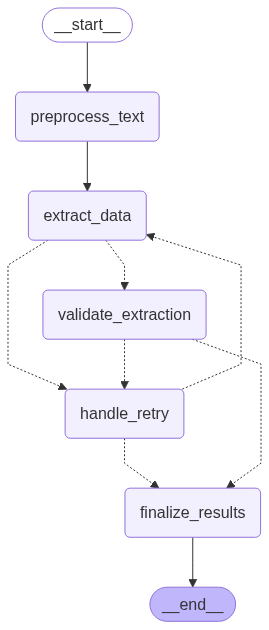

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(extraction_graph.get_graph().draw_mermaid_png()))

In [17]:
# Test function for the extraction pipeline
def test_extraction_pipeline(text: str, paper_id: str = "test_paper") -> dict:
    """Test the extraction pipeline with given text."""
    
    print(f"🚀 Testing extraction pipeline with: {paper_id}")
    print(f"📏 Input text length: {len(text):,} characters")
    print("=" * 60)
    
    # Create initial state
    initial_state = create_initial_state(text, paper_id)
    
    # Run the extraction graph
    try:
        result = extraction_graph.invoke(initial_state)
        return result["final_result"]
    except Exception as e:
        print(f"❌ Pipeline execution failed: {str(e)}")
        return {
            "paper_id": paper_id,
            "success": False,
            "error_message": str(e),
            "data": None
        }

In [18]:
from pathlib import Path

article_folder = "md_articles"
input_articles = [Path(f"md_articles/article{i}/auto/article{i}.md") for i in range(1, 6)]
result_list = []

for article in input_articles:
    with open(article, 'r', encoding='utf-8') as f:
        content = f.read()
    result = test_extraction_pipeline(content, article.stem)
    result_list.append(result)



🚀 Testing extraction pipeline with: article1
📏 Input text length: 67,935 characters
📝 Preprocessing text for paper: article1
   📊 Original length: 67,935 chars
   📊 Cleaned length: 67,594 chars
   🎯 Estimated tokens: ~16,898
🔍 Extracting data from paper: article1
   📤 Sending request to OpenRouter API (DeepSeek-v3)...
   📊 Text length: 67,594 characters
   🔄 Retry attempt: 1
   📥 Received response from OpenRouter (DeepSeek-v3)
   📊 Response length: 3,995 characters
   ✅ Pydantic validation successful
   📊 Extracted 4 AEM entries
   ⏱️  Processing completed in 25.18 seconds
   ✅ Routing to validation (extraction succeeded)
✅ Validating extraction for paper: article1
   📊 Validation Results:
      🎯 Total AEM entries: 4
      ✅ Entries with data: 4 (100.0%)
      📈 Property completeness: 13/16 (81.2%)
      🏆 Quality assessment: HIGH
   🎯 Routing to finalization (validation passed)
📋 Finalizing results for paper: article1
   ✅ Results finalized
   📊 Success: True
   ⏱️  Processing time: 

# 步骤8：提取结果处理与数据结构化

## 🔧 数据处理流程

在成功提取AEM数据后，我们需要将LLM的结构化输出转换为易于分析的格式。这一步骤包括：

### 🎯 核心处理任务
1. **数据扁平化** - 将嵌套的JSON结构转换为表格形式
2. **格式标准化** - 统一数值和单位的显示格式
3. **属性映射** - 将复杂的属性结构映射为独立的列
4. **数据验证** - 确保数据完整性和一致性

### 📋 输出格式设计
- **`document_title`** - 论文标识符
- **`aem_name`** - AEM膜材料名称
- **`oc_*`** - OH⁻导电性相关属性 (Conductivity)
- **`sr_*`** - 溶胀比相关属性 (Swelling Ratio)
- **`ts_*`** - 拉伸强度相关属性 (Tensile Strength)
- **`wu_*`** - 水吸收相关属性 (Water Uptake)

### 🚀 处理策略
- **灵活性**: 支持单一值和列表值的自动处理
- **容错性**: 处理缺失或格式不一致的数据
- **可扩展性**: 配置驱动的属性映射系统


In [19]:
import pandas as pd
import sqlite3

# Define the structure for each high-level property
PROPERTY_CONFIGS = {
    "oh_conductivity": {
        "oc_oh_conductivity": lambda x: f"{x['value']} ({x['unit']})" if x else None,
        "oc_testing_temperature": lambda x: f"{x['value']} ({x['unit']})" if x else None,
    },
    "swelling_ratio": {
        "sr_swelling_ratio": lambda x: f"{x['value']} ({x['unit']})" if x else None,
        "sr_testing_temperature": lambda x: f"{x['value']} ({x['unit']})" if x else None,
    },
    "tensile_strength": {
        "ts_tensile_strength": lambda x: str(x) if x is not None else None,
    },
    "water_uptake": {
        "wu_water_uptake": lambda x: f"{x['value']} ({x['unit']})" if x else None,
        "wu_testing_temperature": lambda x: f"{x['value']} ({x['unit']})" if x else None,
    }
}

# Process each result in the result_list
flattened_data = []
for result in result_list:
    data_entries = result['data']['data_entries']
    for entry in data_entries:
        row = {
            "document_title": result['paper_id'],
            "aem_name": entry.get('aem_name')
        }
        for prop_key, config in PROPERTY_CONFIGS.items():
            property_data = entry.get(prop_key)
            if isinstance(property_data, dict):
                for sub_field_name, formatter in config.items():
                    actual_key = sub_field_name.split('_', 1)[1]
                    row[sub_field_name] = formatter(property_data.get(actual_key))
            elif isinstance(property_data, list):
                for sub_field_name, formatter in config.items():
                    actual_key = sub_field_name.split('_', 1)[1]
                    values = [formatter(item.get(actual_key)) for item in property_data if isinstance(item, dict)]
                    row[sub_field_name] = str(values[0]) if values else None
        flattened_data.append(row)

# Convert to DataFrame
df = pd.DataFrame(flattened_data)
display(df.head())

,document_title,aem_name,oc_oh_conductivity,oc_testing_temperature,sr_swelling_ratio,sr_testing_temperature,ts_tensile_strength,wu_water_uptake,wu_testing_temperature
0,article1,QBNTP-MP11,181.2 (mS cm-1),90 (°C),19.7 (%),90 (°C),"{'value': 31.0, 'unit': 'MPa'}",59.4 (%),30 (°C)
1,article1,QBNTP-HP10,NaN,NaN,12.8 (%),30 (°C),"{'value': 30.1, 'unit': 'MPa'}",53.4 (%),30 (°C)
2,article1,QBNTP-PP13,NaN,NaN,7.5 (%),30 (°C),"{'value': 30.1, 'unit': 'MPa'}",50.9 (%),30 (°C)
3,article1,QBNTP,NaN,NaN,16.1 (%),30 (°C),"{'value': 30.1, 'unit': 'MPa'}",45.2 (%),30 (°C)
4,article2,PBPA,123 (mS cm-1),80 (°C),39 (%),60 (°C),"{'value': 35, 'unit': 'MPa'}",121 (%),30 (°C)


In [20]:
# Save to Excel
try:
    df.to_excel("extracted_data.xlsx", index=False)
    print("Data saved to extracted_data.xlsx")
except Exception as e:
    print(f"Error saving data to Excel: {e}")

Data saved to extracted_data.xlsx


In [21]:
# Save to SQLite
try:
    conn = sqlite3.connect('extracted_data.db')
    df.to_sql('extracted_data', conn, if_exists='replace', index=False)
    print("Data saved to extracted_data.db")
except Exception as e:
    print(f"Error saving data to SQLite: {e}")
finally:
    conn.close()

Data saved to extracted_data.db
